In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('all_weather_by_hour_2023-2025_v1.csv')

In [5]:
# or df = db.get_weather_data()

In [ ]:
"""
Given the structure of our database, because of mapping and the use of json columns,
weather information can be loaded into the database in its original format
(directly from the file all_weather_by_hour_2023-2025_v1.csv) without any modifications.

In such case, all modifications to this table's information that are performed below
will be performed with a subset of the weather information from the database weather table
for the period we require (2022.02.24 - 2025.03.01)

This structure allows us to keep the information in the database in its original format
(in which it comes to us), regardless of its source (historical information or daily forecasts).
And its processing will be performed after it is received from the database

For simplicity of the example and better clarity of the analysis, we will work
with the file with historical information “as it is”, and for comparison we will use
a stub table with an example of weather information that module A receives
"""

In [6]:
# example of weather data received by the data_receiver module
# we will use it for comparison and generalization of historical data

daily_df_stub = pd.read_csv('out.csv')

In [7]:
# 1. BASIC PREPARATION

In [8]:
daily_df_stub.columns

Index(['weather_id', 'region_id', 'region_name', 'date', 'time', 'dew', 'icon',
       'snow', 'temp', 'precip', 'source', 'sunset', 'sunrise', 'tempmax',
       'tempmin', 'uvindex', 'winddir', 'datetime', 'humidity', 'pressure',
       'stations', 'windgust', 'feelslike', 'moonphase', 'snowdepth',
       'windspeed', 'cloudcover', 'conditions', 'precipprob', 'preciptype',
       'visibility', 'description', 'precipcover', 'solarenergy',
       'sunsetEpoch', 'feelslikemax', 'feelslikemin', 'sunriseEpoch',
       'datetimeEpoch', 'solarradiation', 'severerisk'],
      dtype='object')

In [9]:
df.columns

Index(['city_latitude', 'city_longitude', 'city_resolvedAddress',
       'city_address', 'city_timezone', 'city_tzoffset', 'day_datetime',
       'day_datetimeEpoch', 'day_tempmax', 'day_tempmin', 'day_temp',
       'day_feelslikemax', 'day_feelslikemin', 'day_feelslike', 'day_dew',
       'day_humidity', 'day_precip', 'day_precipprob', 'day_precipcover',
       'day_snow', 'day_snowdepth', 'day_windgust', 'day_windspeed',
       'day_winddir', 'day_pressure', 'day_cloudcover', 'day_visibility',
       'day_solarradiation', 'day_solarenergy', 'day_uvindex', 'day_sunrise',
       'day_sunriseEpoch', 'day_sunset', 'day_sunsetEpoch', 'day_moonphase',
       'day_conditions', 'day_description', 'day_icon', 'day_source',
       'day_preciptype', 'day_stations', 'hour_datetime', 'hour_datetimeEpoch',
       'hour_temp', 'hour_feelslike', 'hour_humidity', 'hour_dew',
       'hour_precip', 'hour_precipprob', 'hour_snow', 'hour_snowdepth',
       'hour_preciptype', 'hour_windgust', 'hour_windsp

In [10]:
# data we decided to exclude after performing the analysis
weather_exclude = [
# the model aims for hourly predictions, so hourly data provides much finer granularity.
# some daily context that does not occur in hourly reports is kept, the rest can be derived
# is also consistent with the idea of enriching hourly values with daily values, which is described and followed by the daily weather collector
"day_temp",
"day_dew",
"day_humidity",
"day_precip",
"day_precipprob",
"day_snow",
"day_snowdepth",
"day_windgust",
"day_windspeed",
"day_winddir",
"day_pressure",
"day_cloudcover",
"day_visibility",
"day_solarradiation",
"day_solarenergy",
"day_uvindex",
"day_preciptype",
# date and time are already captured in standard date and time columns
"day_datetimeEpoch",
"hour_datetimeEpoch",
"day_sunsetEpoch",
"day_sunriseEpoch",
# derived metric calculated from actual temperature and other features
"day_feelslike",
'day_feelslikemax',
'day_feelslikemin',
"hour_feelslike",
# redundant, most of the values are logically derived from other parameters (cloudcover, temperature, windspeed)
# those that are not are fully described by preciptype (and its binary derivatives)
"day_conditions",
"hour_conditions",
"day_description",
# metadata
"day_source",
"hour_source",
"hour_stations",
"day_stations",
"day_icon",
"hour_icon",
# geographic details are not necessary, it is covered by the regions table of the database
"city_latitude",
"city_longitude",
"city_resolvedAddress",
"city_timezone",
"city_tzoffset",
"hour_uvindex",
# redundant with other variables (like cloudcover, sunrise, sunset), real-world impact on our target variable is unclear
# in addition, have a large number of missing values
"hour_solarenergy",
"hour_solarradiation",
]

In [11]:
df = df.drop(weather_exclude, axis=1)

In [12]:
df.columns

Index(['city_address', 'day_datetime', 'day_tempmax', 'day_tempmin',
       'day_precipcover', 'day_sunrise', 'day_sunset', 'day_moonphase',
       'hour_datetime', 'hour_temp', 'hour_humidity', 'hour_dew',
       'hour_precip', 'hour_precipprob', 'hour_snow', 'hour_snowdepth',
       'hour_preciptype', 'hour_windgust', 'hour_windspeed', 'hour_winddir',
       'hour_pressure', 'hour_visibility', 'hour_cloudcover'],
      dtype='object')

In [13]:
# converting column names to the format found in the daily weather reports for the purpose of unification

name_keys={
    'city_address':'region_name',
    'day_datetime':'date',
    'hour_datetime':'time',
    'hour_dew':'dew',
    'hour_snow':'snow',
    'hour_temp':'temp',
    'hour_precip':'precip',
    'day_sunset':'sunset',
    'day_sunrise':'sunrise',
    'day_tempmax':'tempmax',
    'day_tempmin':'tempmin',
    'hour_winddir':'winddir',
    'hour_humidity':'humidity',
    'hour_pressure':'pressure',
    'hour_windgust':'windgust',
    'day_moonphase':'moonphase',
    'hour_snowdepth':'snowdepth',
    'hour_windspeed':'windspeed',
    'hour_cloudcover':'cloudcover',
    'hour_precipprob':'precipprob',
    'hour_preciptype':'preciptype',
    'hour_visibility':'visibility',
    'day_precipcover':'precipcover',
}

In [14]:
df = df[name_keys.keys()].rename(name_keys,axis=1)

In [15]:
df['date'] = pd.to_datetime(df['date'])
df['datetime'] = pd.to_datetime(df['date'].dt.date.astype(str) + ' ' + df['time'])

In [16]:
df.columns

Index(['region_name', 'date', 'time', 'dew', 'snow', 'temp', 'precip',
       'sunset', 'sunrise', 'tempmax', 'tempmin', 'winddir', 'humidity',
       'pressure', 'windgust', 'moonphase', 'snowdepth', 'windspeed',
       'cloudcover', 'precipprob', 'preciptype', 'visibility', 'precipcover',
       'datetime'],
      dtype='object')

In [17]:
df.dtypes

region_name            object
date           datetime64[ns]
time                   object
dew                   float64
snow                  float64
temp                  float64
precip                float64
sunset                 object
sunrise                object
tempmax               float64
tempmin               float64
winddir               float64
humidity              float64
pressure              float64
windgust              float64
moonphase             float64
snowdepth             float64
windspeed             float64
cloudcover            float64
precipprob            float64
preciptype             object
visibility            float64
precipcover           float64
datetime       datetime64[ns]
dtype: object

In [18]:
df.shape

(608304, 24)

In [19]:
df['region_name'].unique()

array(['Lutsk,Ukraine', 'Kropyvnytskyi,Ukraine', 'Dnipro,Ukraine',
       'Kyiv,Ukraine', 'Kherson,Ukraine', 'Chernivtsi,Ukraine',
       'Chernihiv,Ukraine', 'Odesa,Ukraine', 'Mykolaiv,Ukraine',
       'Kharkiv,Ukraine', 'Khmelnytskyi,Ukraine', 'Donetsk,Ukraine',
       'Uzhgorod,Ukraine', 'Zaporozhye,Ukraine', 'Rivne,Ukraine',
       'Zhytomyr,Ukraine', 'Ternopil,Ukraine', 'Poltava,Ukraine',
       'Lviv,Ukraine', 'Ivano-Frankivsk,Ukraine', 'Cherkasy,Ukraine',
       'Sumy,Ukraine', 'Vinnytsia,Ukraine'], dtype=object)

In [20]:
# considering that we receive information about alarms separately for Kiev and Kiev Oblast, we duplicate information to simplify  merging of datasets in the future
# similar logic is applied in the daily weather collector as well

def duplicate_kyiv_as_region(input_df: pd.DataFrame):
    kyiv_city_rows = input_df[input_df['region_name'] == 'Kyiv,Ukraine'].copy()
    kyiv_city_rows['region_name'] = 'Kyiv City,Ukraine'
    output_df = pd.concat([input_df, kyiv_city_rows], ignore_index=True)
    return output_df

print("Original 'Kyiv,Ukraine' count:", len(df[df['region_name'] == 'Kyiv,Ukraine']))

df = duplicate_kyiv_as_region(df)

print("Modified 'Kyiv,Ukraine' count:", len(df[df['region_name'] == 'Kyiv,Ukraine']))
print("Modified 'Kyiv, Region' count:", len(df[df['region_name'] == 'Kyiv City,Ukraine']))

Original 'Kyiv,Ukraine' count: 26448
Modified 'Kyiv,Ukraine' count: 26448
Modified 'Kyiv, Region' count: 26448


In [21]:
df.shape

(634752, 24)

In [22]:
df['region_name'].unique()

array(['Lutsk,Ukraine', 'Kropyvnytskyi,Ukraine', 'Dnipro,Ukraine',
       'Kyiv,Ukraine', 'Kherson,Ukraine', 'Chernivtsi,Ukraine',
       'Chernihiv,Ukraine', 'Odesa,Ukraine', 'Mykolaiv,Ukraine',
       'Kharkiv,Ukraine', 'Khmelnytskyi,Ukraine', 'Donetsk,Ukraine',
       'Uzhgorod,Ukraine', 'Zaporozhye,Ukraine', 'Rivne,Ukraine',
       'Zhytomyr,Ukraine', 'Ternopil,Ukraine', 'Poltava,Ukraine',
       'Lviv,Ukraine', 'Ivano-Frankivsk,Ukraine', 'Cherkasy,Ukraine',
       'Sumy,Ukraine', 'Vinnytsia,Ukraine', 'Kyiv City,Ukraine'],
      dtype=object)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634752 entries, 0 to 634751
Data columns (total 24 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   region_name  634752 non-null  object        
 1   date         634752 non-null  datetime64[ns]
 2   time         634752 non-null  object        
 3   dew          634752 non-null  float64       
 4   snow         634752 non-null  float64       
 5   temp         634752 non-null  float64       
 6   precip       634643 non-null  float64       
 7   sunset       634752 non-null  object        
 8   sunrise      634752 non-null  object        
 9   tempmax      634752 non-null  float64       
 10  tempmin      634752 non-null  float64       
 11  winddir      634752 non-null  float64       
 12  humidity     634752 non-null  float64       
 13  pressure     634752 non-null  float64       
 14  windgust     634752 non-null  float64       
 15  moonphase    634752 non-null  floa

In [24]:
df.head(10)

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,windgust,moonphase,snowdepth,windspeed,cloudcover,precipprob,preciptype,visibility,precipcover,datetime
0,"Lutsk,Ukraine",2022-02-24,00:00:00,0.8,0.1,2.4,0.000,17:51:06,07:13:36,4.9,...,31.3,0.77,0.2,15.5,91.5,0.0,['snow'],0.0,4.17,2022-02-24 00:00:00
1,"Lutsk,Ukraine",2022-02-24,01:00:00,0.6,0.0,2.4,0.000,17:51:06,07:13:36,4.9,...,27.7,0.77,0.2,14.8,88.2,0.0,['snow'],0.2,4.17,2022-02-24 01:00:00
2,"Lutsk,Ukraine",2022-02-24,02:00:00,1.2,0.0,2.9,0.000,17:51:06,07:13:36,4.9,...,29.2,0.77,0.1,14.4,100.0,0.0,['snow'],10.0,4.17,2022-02-24 02:00:00
3,"Lutsk,Ukraine",2022-02-24,03:00:00,0.3,0.0,2.3,0.000,17:51:06,07:13:36,4.9,...,23.8,0.77,0.1,13.3,92.0,0.0,['snow'],0.1,4.17,2022-02-24 03:00:00
4,"Lutsk,Ukraine",2022-02-24,04:00:00,0.1,0.0,1.9,0.000,17:51:06,07:13:36,4.9,...,24.5,0.77,0.1,13.3,93.8,0.0,['snow'],0.0,4.17,2022-02-24 04:00:00
5,"Lutsk,Ukraine",2022-02-24,05:00:00,0.6,0.0,1.9,0.000,17:51:06,07:13:36,4.9,...,23.4,0.77,0.1,10.8,100.0,0.0,NaN,10.0,4.17,2022-02-24 05:00:00
6,"Lutsk,Ukraine",2022-02-24,06:00:00,1.0,0.0,2.0,0.000,17:51:06,07:13:36,4.9,...,20.9,0.77,0.1,10.8,100.0,0.0,['snow'],10.0,4.17,2022-02-24 06:00:00
7,"Lutsk,Ukraine",2022-02-24,07:00:00,1.0,0.0,2.0,0.000,17:51:06,07:13:36,4.9,...,19.1,0.77,0.1,10.8,100.0,0.0,['snow'],10.0,4.17,2022-02-24 07:00:00
8,"Lutsk,Ukraine",2022-02-24,08:00:00,0.6,0.0,1.8,0.118,17:51:06,07:13:36,4.9,...,16.9,0.77,0.1,7.2,100.0,100.0,['snow'],4.4,4.17,2022-02-24 08:00:00
9,"Lutsk,Ukraine",2022-02-24,09:00:00,1.0,0.0,2.0,0.000,17:51:06,07:13:36,4.9,...,15.5,0.77,0.1,10.8,100.0,0.0,NaN,2.0,4.17,2022-02-24 09:00:00


In [25]:
# 2. CHECKING FOR DUPLICATES

In [26]:
# checking for duplicates
df.duplicated(subset=['region_name', 'date', 'time']).sum()

np.int64(72)

In [28]:
df.drop_duplicates(subset=['region_name', 'date', 'time'], inplace=True)

In [29]:
df.duplicated(subset=['region_name', 'date', 'time']).sum()

np.int64(0)

In [30]:
# 3. BASIC VALUE DERIVATION

In [31]:
df['precipprob'].unique()

array([  0., 100.])

In [32]:
# given that precipprob takes on only two values, we convert it to binary format

df['precipprob_binary'] = (df['precipprob'] > 0).astype(int)
df = df.drop(['precipprob'], axis=1)

In [33]:
df['preciptype'].value_counts()

preciptype
['rain']            44850
['rain', 'snow']    12725
['snow']             9806
['freezingrain']      127
['ice']                 4
Name: count, dtype: int64

In [34]:
# converting the text column “preciptype” into binary format. we ignore [‘freezingrain’] and [‘ice’] due to extremely low occurrence numbers

target_conditions = {
    'rain_bin': "['rain']",
    'snow_bin': "['snow']",
    'rain_snow_bin': "['rain', 'snow']"
}

for new_col in target_conditions.keys():
    df[new_col] = 0

for new_col, condition in target_conditions.items():
    mask = (df['preciptype'] == condition)
    df.loc[mask, new_col] = 1

df = df.drop('preciptype', axis=1)

In [35]:
df['rain_bin'].value_counts()

rain_bin
0    589830
1     44850
Name: count, dtype: int64

In [36]:
df['snow_bin'].value_counts()

snow_bin
0    624874
1      9806
Name: count, dtype: int64

In [37]:
df['rain_snow_bin'].value_counts()

rain_snow_bin
0    621955
1     12725
Name: count, dtype: int64

In [38]:
df.head(10)

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,snowdepth,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin
0,"Lutsk,Ukraine",2022-02-24,00:00:00,0.8,0.1,2.4,0.000,17:51:06,07:13:36,4.9,...,0.2,15.5,91.5,0.0,4.17,2022-02-24 00:00:00,0,0,1,0
1,"Lutsk,Ukraine",2022-02-24,01:00:00,0.6,0.0,2.4,0.000,17:51:06,07:13:36,4.9,...,0.2,14.8,88.2,0.2,4.17,2022-02-24 01:00:00,0,0,1,0
2,"Lutsk,Ukraine",2022-02-24,02:00:00,1.2,0.0,2.9,0.000,17:51:06,07:13:36,4.9,...,0.1,14.4,100.0,10.0,4.17,2022-02-24 02:00:00,0,0,1,0
3,"Lutsk,Ukraine",2022-02-24,03:00:00,0.3,0.0,2.3,0.000,17:51:06,07:13:36,4.9,...,0.1,13.3,92.0,0.1,4.17,2022-02-24 03:00:00,0,0,1,0
4,"Lutsk,Ukraine",2022-02-24,04:00:00,0.1,0.0,1.9,0.000,17:51:06,07:13:36,4.9,...,0.1,13.3,93.8,0.0,4.17,2022-02-24 04:00:00,0,0,1,0
5,"Lutsk,Ukraine",2022-02-24,05:00:00,0.6,0.0,1.9,0.000,17:51:06,07:13:36,4.9,...,0.1,10.8,100.0,10.0,4.17,2022-02-24 05:00:00,0,0,0,0
6,"Lutsk,Ukraine",2022-02-24,06:00:00,1.0,0.0,2.0,0.000,17:51:06,07:13:36,4.9,...,0.1,10.8,100.0,10.0,4.17,2022-02-24 06:00:00,0,0,1,0
7,"Lutsk,Ukraine",2022-02-24,07:00:00,1.0,0.0,2.0,0.000,17:51:06,07:13:36,4.9,...,0.1,10.8,100.0,10.0,4.17,2022-02-24 07:00:00,0,0,1,0
8,"Lutsk,Ukraine",2022-02-24,08:00:00,0.6,0.0,1.8,0.118,17:51:06,07:13:36,4.9,...,0.1,7.2,100.0,4.4,4.17,2022-02-24 08:00:00,1,0,1,0
9,"Lutsk,Ukraine",2022-02-24,09:00:00,1.0,0.0,2.0,0.000,17:51:06,07:13:36,4.9,...,0.1,10.8,100.0,2.0,4.17,2022-02-24 09:00:00,0,0,0,0


In [39]:
# 4. MISSING VALUES CHECKS

In [40]:
df.isnull().sum()

region_name               0
date                      0
time                      0
dew                       0
snow                      0
temp                      0
precip                  109
sunset                    0
sunrise                   0
tempmax                   0
tempmin                   0
winddir                   0
humidity                  0
pressure                  0
windgust                  0
moonphase                 0
snowdepth                 0
windspeed                 0
cloudcover                0
visibility           289338
precipcover               0
datetime                  0
precipprob_binary         0
rain_bin                  0
snow_bin                  0
rain_snow_bin             0
dtype: int64

In [41]:
# working with precip
df['precip'].value_counts()

precip
0.000     593402
0.100      12301
0.200       4308
0.300       2901
0.400       2051
           ...  
2.069          1
19.591         1
0.510          1
2.074          1
44.000         1
Name: count, Length: 1979, dtype: int64

In [42]:
# the amount of NaNs it is small, and the most frequent value is 0, so median is fine
median_precip = df['precip'].median()
df['precip'] = df['precip'].fillna(median_precip)

In [43]:
# working with visibility
df['visibility'] = df['visibility'].replace('', np.nan)
df['visibility'] = pd.to_numeric(df['visibility'], errors='coerce')
df['visibility_missing'] = df['visibility'].isnull()

print(f"Total rows: {len(df)}")
print(f"Rows with missing visibility: {df['visibility_missing'].sum()}")
print(f"Percentage missing: {df['visibility_missing'].mean() * 100:.2f}%")

Total rows: 634680
Rows with missing visibility: 289338
Percentage missing: 45.59%


In [44]:
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 12

colors = [
    "#008bc9", "#238ccf", "#448ad9", "#5d88dd", "#7087e2", "#837ee3", "#9881e4",
    "#a582dd", "#bd78de", "#cf72d8", "#dd6ecf", "#e966c7", "#f866ba", "#fa62a8",
    "#ff61a0", "#ff6294", "#ff6582", "#ff6c72", "#ff7262", "#ff7a51", "#ff8440",
    "#ff921f", "#ff9913", "#ffa31c"
]

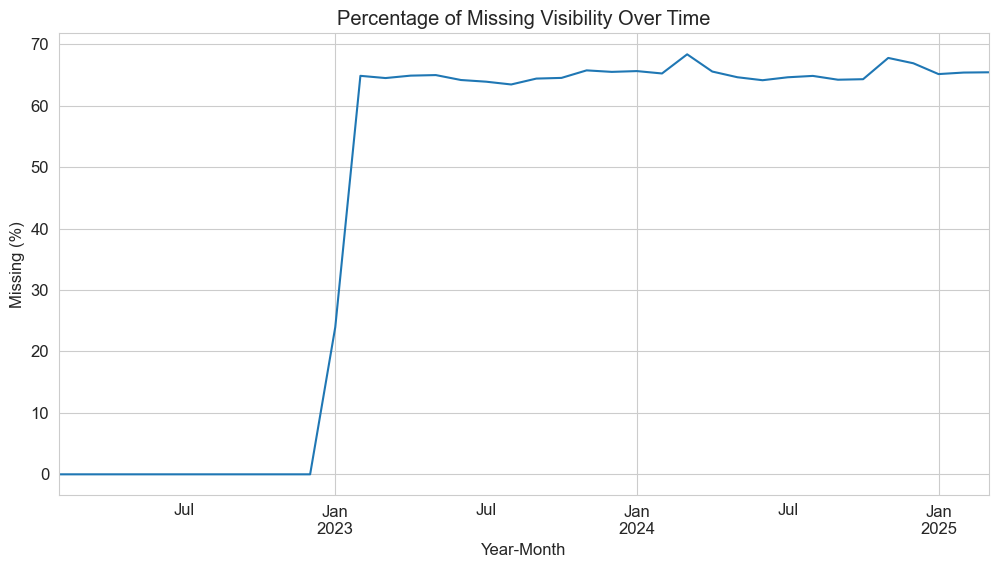

In [45]:
# there was a major shift in data collection starting at December 2022 and stabilizing by February 2023. data before this period is complete (hourly)

df['year_month'] = df['datetime'].dt.to_period('M')
missing_over_time = df.groupby('year_month')['visibility_missing'].mean() * 100

missing_over_time.plot(kind='line', figsize=(12, 6))
plt.title('Percentage of Missing Visibility Over Time')
plt.ylabel('Missing (%)')
plt.xlabel('Year-Month')
plt.grid(True)
plt.show()

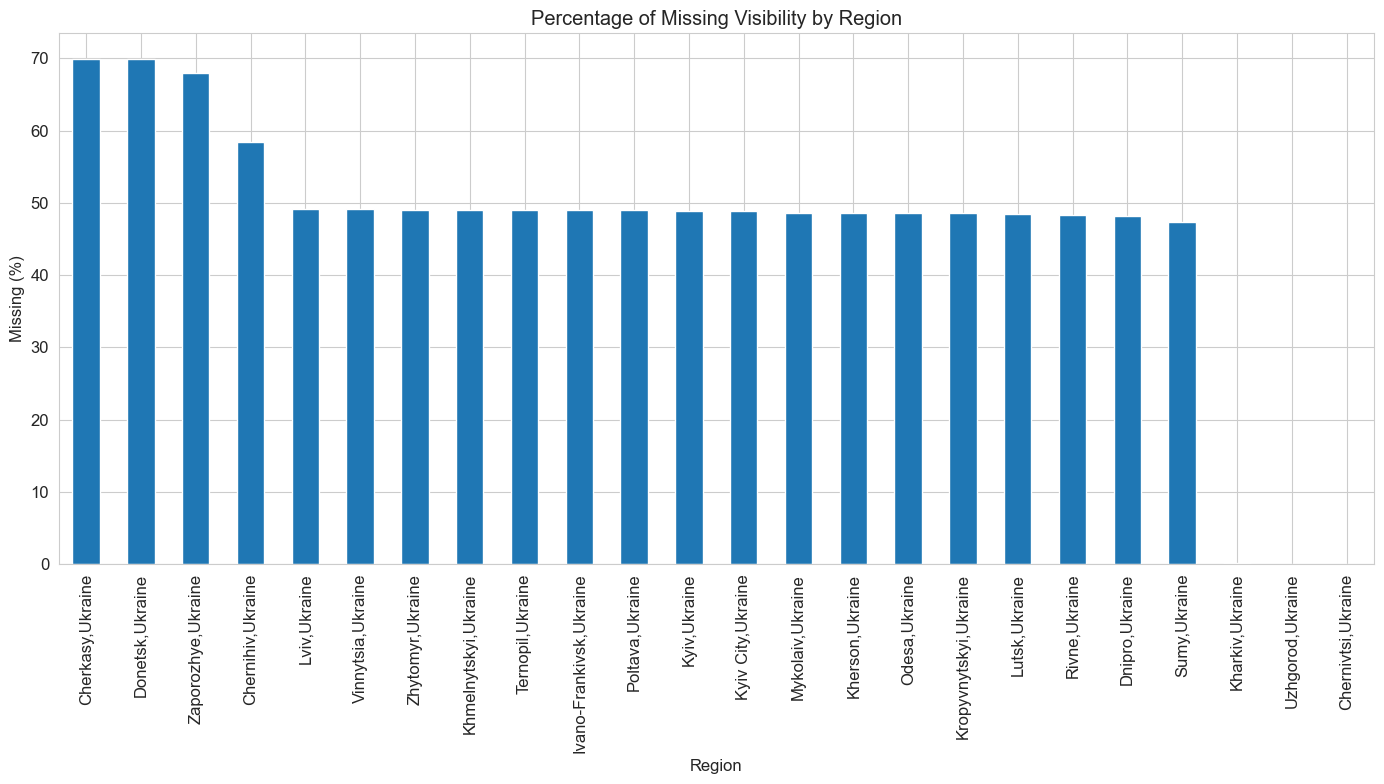

In [46]:
missing_by_region = df.groupby('region_name')['visibility_missing'].mean() * 100
missing_by_region = missing_by_region.sort_values(ascending=False)

missing_by_region.plot(kind='bar', figsize=(14, 8))
plt.title('Percentage of Missing Visibility by Region')
plt.ylabel('Missing (%)')
plt.xlabel('Region')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

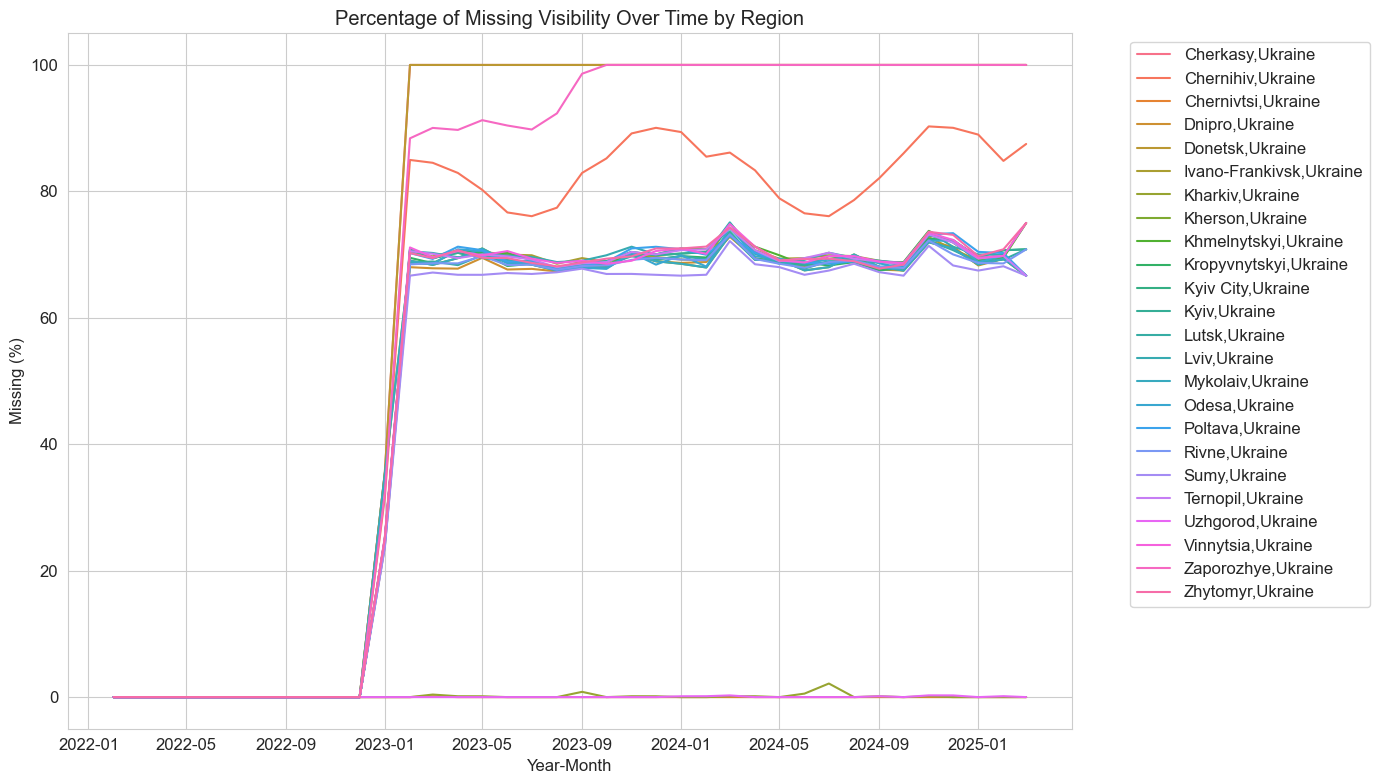

In [47]:
missing_by_region_time = df.groupby(['region_name', 'year_month'])['visibility_missing'].mean().reset_index()
missing_by_region_time['missing_perc'] = missing_by_region_time['visibility_missing'] * 100
missing_by_region_time['year_month_dt'] = missing_by_region_time['year_month'].dt.to_timestamp()

plt.figure(figsize=(14, 8))
sns.lineplot(data=missing_by_region_time, x='year_month_dt', y='missing_perc', hue='region_name')
plt.title('Percentage of Missing Visibility Over Time by Region')
plt.ylabel('Missing (%)')
plt.xlabel('Year-Month')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

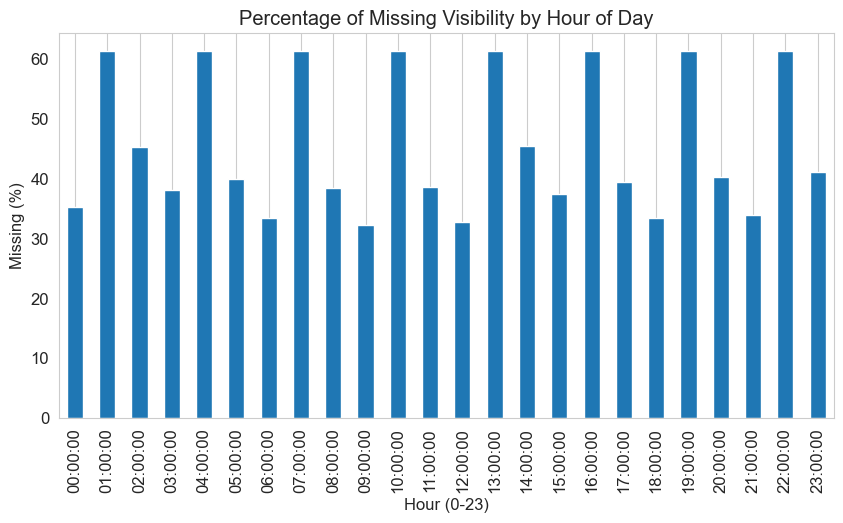

In [48]:
missing_by_hour = df.groupby('time')['visibility_missing'].mean() * 100

missing_by_hour.plot(kind='bar', figsize=(10, 5))
plt.title('Percentage of Missing Visibility by Hour of Day')
plt.ylabel('Missing (%)')
plt.xlabel('Hour (0-23)')
plt.grid(axis='y')
plt.show()

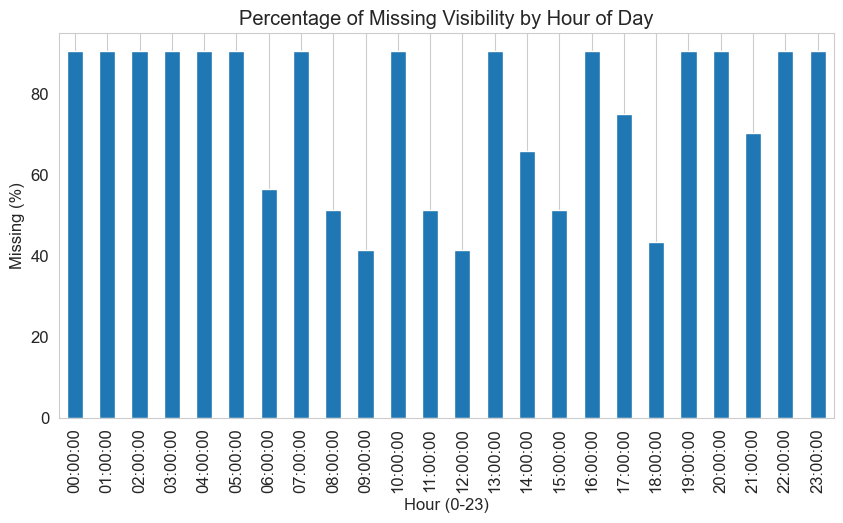

In [49]:
missing_by_hour = (
    df[(df["region_name"] == "Chernihiv,Ukraine") & (df["date"] >= "2022-11-01")]
    .groupby("time")["visibility_missing"]
    .mean() * 100
)

missing_by_hour.plot(kind='bar', figsize=(10, 5))
plt.title('Percentage of Missing Visibility by Hour of Day')
plt.ylabel('Missing (%)')
plt.xlabel('Hour (0-23)')
plt.grid(axis='y')
plt.show()

In [50]:
# the change was not uniform:
# unaffected: Kharkiv, Uzhgorod, Chernivtsi. Consistently provide hourly visibility data throughout.
# switched to 3-Hourly (implied): Most regions (~50% missing overall, ~70% missing post-Dec 2023).
    # the hourly pattern (high missingness at 1, 4, 7, 10, 13, 16, 19, 22) strongly indicates data
    # is now primarily reported every 3 hours (e.g., at 0, 3, 6, 9, 12, 15, 18, 21). the ~70% missing
    # rate reflects that 16 out of 24 hourly slots are now empty within this group.
# stopped reporting: Cherkasy and Zaporizhzhya. Stopped providing visibility data entirely after Dec 2023 (100% missing).
# high missing rate: Chernihiv has a very high (85%) but not total missing rate post-Dec 2023.
    # unlike most regions, Chernihiv shows high missing percentages across all hours. the visibility reporting for Chernihiv
    # became highly inconsistent or significantly reduced, not just switched to a less frequent but regular interval

In [51]:
# we are using hybrid approach tailored to each region group
# for regions that switched to 3-hourly reporting after the transition date we apply interpolation (reports are on the hour, method='linear' is sufficient)
# for regions with 100% missing data post-switch interpolation is impossible as there are no data to interpolate.
# we use their historical medians (we find their typical visibility before the transition and use it to fill missing values after it)
# remaining empty values (there is a small number of them) are filled with the median visibility value

TRANSITION_DATE = pd.to_datetime('2023-01-01')
REGIONS_UNAFFECTED = ['Kharkiv,Ukraine', 'Uzhgorod,Ukraine', 'Chernivtsi,Ukraine']
REGIONS_3_HOURLY = [
    'Lutsk,Ukraine', 'Kropyvnytskyi,Ukraine', 'Dnipro,Ukraine', 'Kyiv,Ukraine',
    'Kherson,Ukraine', 'Odesa,Ukraine', 'Mykolaiv,Ukraine', 'Khmelnytskyi,Ukraine',
    'Rivne,Ukraine', 'Zhytomyr,Ukraine', 'Ternopil,Ukraine', 'Poltava,Ukraine',
    'Lviv,Ukraine', 'Ivano-Frankivsk,Ukraine', 'Sumy,Ukraine', 'Vinnytsia,Ukraine', 'Kyiv City,Ukraine'
]
REGIONS_MEDIAN_IMPUTE = ['Cherkasy,Ukraine', 'Zaporozhye,Ukraine', 'Chernihiv,Ukraine', 'Donetsk,Ukraine']


print(f"Initial missing visibility count: {df['visibility'].isna().sum()}")
df = df.sort_values(by=['region_name', 'datetime']).reset_index(drop=True)
df['visibility_was_reported'] = df['visibility'].notna().astype(int)


# 1
mask_interpolate = (
    df['region_name'].isin(REGIONS_3_HOURLY) &
    (df['datetime'] >= TRANSITION_DATE)
)
interpolated_values = df.loc[mask_interpolate].groupby(
    ['region_name', pd.Grouper(key='datetime', freq='D')]
)['visibility'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
df.loc[mask_interpolate, 'visibility'] = interpolated_values


# 2
historical_medians = {}
for region in REGIONS_MEDIAN_IMPUTE:
    mask_historical = (
        (df['region_name'] == region) &
        (df['datetime'] < TRANSITION_DATE) &
        (df['visibility_was_reported'] == 1)
    )

    median_val = df.loc[mask_historical, 'visibility'].median()
    historical_medians[region] = median_val


# 3
mask_median_impute = (
    df['region_name'].isin(REGIONS_MEDIAN_IMPUTE) &
    (df['datetime'] >= TRANSITION_DATE) &
    (df['visibility'].isna())
)
region_to_median_map = pd.Series(historical_medians)
impute_values_median = df.loc[mask_median_impute, 'region_name'].map(region_to_median_map)
df.loc[mask_median_impute, 'visibility'] = impute_values_median


# 4
missing_count = df['visibility'].isna().sum()
print(f"Missing values in 'visibility' after processing: {missing_count}")
df['visibility'] = df['visibility'].fillna(df['visibility'].median())


# 5
final_missing_count = df['visibility'].isna().sum()
print(f"Final missing visibility count: {final_missing_count}")

Initial missing visibility count: 289338
Missing values in 'visibility' after processing: 5143
Final missing visibility count: 0


In [52]:
# exclude tools
visibility_tools_exclude = [
"visibility_missing",
"year_month",
"visibility_was_reported",
]
df = df.drop(visibility_tools_exclude, axis=1)

In [53]:
df.isnull().sum()

region_name          0
date                 0
time                 0
dew                  0
snow                 0
temp                 0
precip               0
sunset               0
sunrise              0
tempmax              0
tempmin              0
winddir              0
humidity             0
pressure             0
windgust             0
moonphase            0
snowdepth            0
windspeed            0
cloudcover           0
visibility           0
precipcover          0
datetime             0
precipprob_binary    0
rain_bin             0
snow_bin             0
rain_snow_bin        0
dtype: int64

In [54]:
# 5. RANGE AND PLAUSIBILITY CHECKS

In [55]:
df.describe()

,date,dew,snow,temp,precip,tempmax,tempmin,winddir,humidity,pressure,...,snowdepth,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin
count,634680,634680.000000,634680.000000,634680.000000,634680.000000,634680.000000,634680.000000,634680.000000,634680.000000,634680.000000,...,634680.000000,634680.000000,634680.000000,634680.000000,634680.000000,634680,634680.000000,634680.000000,634680.000000,634680.000000
mean,2023-08-28 12:25:01.259217152,5.264697,0.005123,10.708107,0.086673,15.172513,6.255813,190.076961,72.849238,1016.912516,...,0.603912,11.351286,64.927744,16.217823,6.486600,2023-08-28 23:55:04.730573312,0.064866,0.070666,0.015450,0.020049
min,2022-02-24 00:00:00,-25.900000,0.000000,-50.300000,0.000000,-14.300000,-50.300000,0.000000,8.460000,973.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2022-02-24 00:00:00,0.000000,0.000000,0.000000,0.000000
25%,2022-11-26 00:00:00,-0.400000,0.000000,2.400000,0.000000,5.800000,-0.200000,98.400000,59.270000,1011.200000,...,0.000000,7.200000,30.000000,10.000000,0.000000,2022-11-26 12:00:00,0.000000,0.000000,0.000000,0.000000
50%,2023-08-29 00:00:00,5.300000,0.000000,10.200000,0.000000,15.100000,6.100000,192.300000,77.370000,1016.600000,...,0.000000,10.800000,80.000000,11.666667,4.170000,2023-08-29 00:00:00,0.000000,0.000000,0.000000,0.000000
75%,2024-05-30 00:00:00,11.500000,0.000000,18.400000,0.000000,24.600000,13.200000,287.400000,89.010000,1022.000000,...,0.000000,15.100000,99.900000,24.100000,8.330000,2024-05-30 12:00:00,0.000000,0.000000,0.000000,0.000000
max,2025-03-01 00:00:00,24.600000,4.200000,60.400000,300.000000,60.400000,27.200000,360.000000,100.000000,1050.000000,...,107.000000,90.000000,100.000000,75.000000,100.000000,2025-03-01 23:00:00,1.000000,1.000000,1.000000,1.000000
std,NaN,7.657243,0.048995,9.790574,2.103670,10.600728,8.160008,106.374822,19.452404,8.695324,...,2.590395,6.504627,37.313957,9.271529,11.980638,NaN,0.246289,0.256266,0.123335,0.140170


In [56]:
# we see unusual values in temp (and its derivatives tempmax and tempmin), windspeed and windgust

In [57]:
# checking temp, tempmin and tempmax
df[df['temp'] == 60.4]

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,snowdepth,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin
584906,"Zaporozhye,Ukraine",2022-07-03,21:00:00,11.5,0.0,60.4,0.0,20:41:03,04:45:53,60.4,...,0.0,4.7,40.0,2.0,0.0,2022-07-03 21:00:00,0,0,0,0


In [58]:
i = df.index.get_loc(584906)
col_idx = df.columns.get_loc('temp')
windspeed_data = df.iloc[i-3:i+4, col_idx]
windspeed_data

584903    27.8
584904    27.2
584905    26.1
584906    60.4
584907    23.2
584908    22.3
584909    21.3
Name: temp, dtype: float64

In [59]:
df.loc[df['temp'] == 60.4, 'temp'] = 24.7

In [60]:
df[df['temp'] == -50.3]

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,snowdepth,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin
587378,"Zaporozhye,Ukraine",2022-10-14,21:00:00,2.3,0.0,-50.3,0.0,17:53:28,06:56:34,14.5,...,0.0,6.1,40.0,2.0,0.0,2022-10-14 21:00:00,0,0,0,0


In [61]:
i = df.index.get_loc(587378)
col_idx = df.columns.get_loc('temp')
windspeed_data = df.iloc[i-3:i+4, col_idx]
windspeed_data

587375    11.9
587376    10.7
587377     9.5
587378   -50.3
587379     7.9
587380     7.2
587381     6.5
Name: temp, dtype: float64

In [62]:
df.loc[df['temp'] == -50.3, 'temp'] = 8.7

In [63]:
df['temp'].max()

np.float64(39.4)

In [64]:
df['temp'].min()

np.float64(-22.5)

In [65]:
df[df['temp'] == 39.4]

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,snowdepth,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin
206079,"Kherson,Ukraine",2024-07-16,15:00:00,17.2,0.0,39.4,0.0,20:38:26,05:12:27,39.4,...,0.0,14.4,90.0,20.0,0.0,2024-07-16 15:00:00,0,0,0,0
391194,"Mykolaiv,Ukraine",2024-07-16,15:00:00,17.2,0.0,39.4,0.0,20:42:12,05:13:42,39.4,...,0.0,14.4,90.0,20.0,0.0,2024-07-16 15:00:00,0,0,0,0


In [66]:
df[df['temp'] == -22.5]

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,snowdepth,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin
492429,"Sumy,Ukraine",2024-01-09,05:00:00,-25.9,0.0,-22.5,0.0,15:54:10,07:41:35,-9.9,...,13.6,10.7,100.0,10.0,0.0,2024-01-09 05:00:00,0,0,0,0


In [67]:
# the remaining max and min values are acceptable. we replace the max and min daily temperature
# and thus also check whether there are errors in their calculation in the other columns.

df['original_tempmax'] = df['tempmax']
df['tempmax'] = df.groupby(['region_name', 'date'])['temp'].transform('max')
changed_rows = df[df['tempmax'] != df['original_tempmax']]
changed_rows

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin,original_tempmax
584885,"Zaporozhye,Ukraine",2022-07-03,00:00:00,10.0,0.0,18.4,0.0,20:41:03,04:45:53,28.5,...,4.3,0.0,24.1,0.0,2022-07-03 00:00:00,0,0,0,0,60.4
584886,"Zaporozhye,Ukraine",2022-07-03,01:00:00,10.4,0.0,17.6,0.0,20:41:03,04:45:53,28.5,...,4.3,0.0,24.1,0.0,2022-07-03 01:00:00,0,0,0,0,60.4
584887,"Zaporozhye,Ukraine",2022-07-03,02:00:00,11.1,0.0,16.9,0.0,20:41:03,04:45:53,28.5,...,4.3,0.0,24.1,0.0,2022-07-03 02:00:00,0,0,0,0,60.4
584888,"Zaporozhye,Ukraine",2022-07-03,03:00:00,18.1,0.0,19.4,0.0,20:41:03,04:45:53,28.5,...,4.3,40.0,2.0,0.0,2022-07-03 03:00:00,0,0,0,0,60.4
584889,"Zaporozhye,Ukraine",2022-07-03,04:00:00,12.1,0.0,15.8,0.0,20:41:03,04:45:53,28.5,...,4.3,0.0,24.1,0.0,2022-07-03 04:00:00,0,0,0,0,60.4
584890,"Zaporozhye,Ukraine",2022-07-03,05:00:00,12.0,0.0,15.5,0.0,20:41:03,04:45:53,28.5,...,4.3,0.0,24.1,0.0,2022-07-03 05:00:00,0,0,0,0,60.4
584891,"Zaporozhye,Ukraine",2022-07-03,06:00:00,12.0,0.0,16.0,0.0,20:41:03,04:45:53,28.5,...,4.7,0.0,24.1,0.0,2022-07-03 06:00:00,0,0,0,0,60.4
584892,"Zaporozhye,Ukraine",2022-07-03,07:00:00,10.9,0.0,18.5,0.0,20:41:03,04:45:53,28.5,...,6.1,0.0,24.1,0.0,2022-07-03 07:00:00,0,0,0,0,60.4
584893,"Zaporozhye,Ukraine",2022-07-03,08:00:00,10.0,0.0,20.8,0.0,20:41:03,04:45:53,28.5,...,10.1,0.0,24.1,0.0,2022-07-03 08:00:00,0,0,0,0,60.4
584894,"Zaporozhye,Ukraine",2022-07-03,09:00:00,17.7,0.0,21.4,0.0,20:41:03,04:45:53,28.5,...,11.5,50.0,3.0,0.0,2022-07-03 09:00:00,0,0,0,0,60.4


In [68]:
# we see that there was an error in the original data when calculating the min value. manual check confirms it, so we replace it

df['original_tempmin'] = df['tempmin']
df['tempmin'] = df.groupby(['region_name', 'date'])['temp'].transform('min')
changed_rows = df[df['tempmin'] != df['original_tempmin']]
changed_rows

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin,original_tempmax,original_tempmin
525876,"Ternopil,Ukraine",2024-10-27,00:00:00,2.9,0.0,3.5,0.0,17:03:40,06:58:36,13.8,...,0.0,4.0,8.33,2024-10-27 00:00:00,0,0,0,0,13.8,2.0
525877,"Ternopil,Ukraine",2024-10-27,01:00:00,2.2,0.0,2.6,0.0,17:03:40,06:58:36,13.8,...,4.4,4.0,8.33,2024-10-27 01:00:00,0,0,0,0,13.8,2.0
525878,"Ternopil,Ukraine",2024-10-27,02:00:00,2.1,0.0,2.4,0.0,17:03:40,06:58:36,13.8,...,43.8,4.0,8.33,2024-10-27 02:00:00,0,0,0,0,13.8,2.0
525879,"Ternopil,Ukraine",2024-10-27,03:00:00,2.7,0.0,3.4,0.0,17:03:40,06:58:36,13.8,...,49.7,4.0,8.33,2024-10-27 03:00:00,0,0,0,0,13.8,2.0
525880,"Ternopil,Ukraine",2024-10-27,04:00:00,2.1,0.0,2.1,0.0,17:03:40,06:58:36,13.8,...,100.0,2.5,8.33,2024-10-27 04:00:00,0,0,0,0,13.8,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587376,"Zaporozhye,Ukraine",2022-10-14,19:00:00,1.8,0.0,10.7,0.0,17:53:28,06:56:34,14.5,...,2.1,24.1,0.00,2022-10-14 19:00:00,0,0,0,0,14.5,-50.3
587377,"Zaporozhye,Ukraine",2022-10-14,20:00:00,2.3,0.0,9.5,0.0,17:53:28,06:56:34,14.5,...,0.0,24.1,0.00,2022-10-14 20:00:00,0,0,0,0,14.5,-50.3
587378,"Zaporozhye,Ukraine",2022-10-14,21:00:00,2.3,0.0,8.7,0.0,17:53:28,06:56:34,14.5,...,40.0,2.0,0.00,2022-10-14 21:00:00,0,0,0,0,14.5,-50.3
587379,"Zaporozhye,Ukraine",2022-10-14,22:00:00,2.0,0.0,7.9,0.0,17:53:28,06:56:34,14.5,...,0.0,24.1,0.00,2022-10-14 22:00:00,0,0,0,0,14.5,-50.3


In [69]:
# exclude tools
weather_tools_exclude = [
"original_tempmax",
"original_tempmin"
]
df = df.drop(weather_tools_exclude, axis=1)

In [70]:
# checking windspeed and windgust
df[df['windspeed'] == 90.0]

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,snowdepth,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin
582890,"Zaporozhye,Ukraine",2022-04-10,21:00:00,3.9,0.0,4.2,14.0,19:22:00,06:00:21,19.4,...,0.0,90.0,40.0,11.0,4.17,2022-04-10 21:00:00,1,1,0,0


In [71]:
i = df.index.get_loc(582890)
col_idx = df.columns.get_loc('windspeed')
windspeed_data = df.iloc[i-3:i+4, col_idx]
windspeed_data

582887    10.4
582888     9.4
582889     9.7
582890    90.0
582891     9.7
582892     7.9
582893     5.8
Name: windspeed, dtype: float64

In [72]:
df.loc[df['windspeed'] == 90.0, 'windspeed'] = 9.7

In [73]:
df['windspeed'].max()

np.float64(86.4)

In [74]:
df[df['windspeed'] == 86.4]

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,snowdepth,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin
590629,"Zaporozhye,Ukraine",2023-02-27,08:00:00,-0.9,0.0,-0.3,2.0,17:20:14,06:24:51,9.5,...,0.0,86.4,10.0,16.0,8.33,2023-02-27 08:00:00,1,0,0,1


In [75]:
i = df.index.get_loc(590629)
col_idx = df.columns.get_loc('windspeed')
windspeed_data = df.iloc[i-3:i+4, col_idx]
windspeed_data

590626     8.3
590627     9.7
590628    11.2
590629    86.4
590630    10.8
590631    10.8
590632    12.2
Name: windspeed, dtype: float64

In [76]:
df.loc[df['windspeed'] == 86.4, 'windspeed'] = 11.0

In [77]:
df['windspeed'].max()

np.float64(64.8)

In [78]:
df[df['windspeed'] == 64.8]

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,snowdepth,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin
589231,"Zaporozhye,Ukraine",2022-12-31,02:00:00,-2.1,0.0,-1.6,0.0,15:56:11,07:28:35,7.0,...,0.0,64.8,40.0,12.0,0.00,2022-12-31 02:00:00,0,0,0,0
589567,"Zaporozhye,Ukraine",2023-01-14,02:00:00,-2.6,0.0,-1.9,0.0,16:12:18,07:24:41,0.9,...,0.0,64.8,40.0,12.0,4.17,2023-01-14 02:00:00,0,0,0,0
591613,"Zaporozhye,Ukraine",2023-04-09,09:00:00,8.4,0.0,8.9,0.0,19:20:14,06:02:48,12.7,...,0.0,64.8,10.0,16.0,37.50,2023-04-09 09:00:00,0,0,0,0


In [79]:
i = df.index.get_loc(589231)
col_idx = df.columns.get_loc('windspeed')
windspeed_data = df.iloc[i-5:i+4, col_idx]
windspeed_data

589226    13.0
589227    11.2
589228     9.7
589229     8.3
589230     6.1
589231    64.8
589232     6.5
589233     6.8
589234     5.8
Name: windspeed, dtype: float64

In [80]:
df.iloc[i, col_idx] = 6.3

In [81]:
i = df.index.get_loc(589567)
col_idx = df.columns.get_loc('windspeed')
windspeed_data = df.iloc[i-5:i+4, col_idx]
windspeed_data

589562    11.5
589563    11.5
589564     5.8
589565    11.2
589566    11.5
589567    64.8
589568    10.8
589569    10.4
589570    10.8
Name: windspeed, dtype: float64

In [82]:
df.iloc[i, col_idx] = 11.1

In [83]:
i = df.index.get_loc(591613)
col_idx = df.columns.get_loc('windspeed')
windspeed_data = df.iloc[i-5:i+4, col_idx]
windspeed_data

591608     7.9
591609     9.4
591610    10.1
591611    11.5
591612    13.3
591613    64.8
591614    12.6
591615    12.6
591616    11.9
Name: windspeed, dtype: float64

In [84]:
df.iloc[i, col_idx] = 12.9

In [85]:
df['windspeed'].max()

np.float64(61.2)

In [86]:
df[df['windspeed'] == 61.2]

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,snowdepth,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin
412053,"Odesa,Ukraine",2023-11-26,20:00:00,-1.6,0.4,-0.9,58.0,16:14:47,07:13:23,2.1,...,10.0,61.2,100.0,0.0,8.33,2023-11-26 20:00:00,1,0,0,1


In [87]:
i = df.index.get_loc(412053)
col_idx = df.columns.get_loc('windspeed')
windspeed_data = df.iloc[i-5:i+4, col_idx]
windspeed_data

412048    54.0
412049    55.4
412050    32.4
412051    58.3
412052    58.3
412053    61.2
412054    54.0
412055    50.8
412056    54.0
Name: windspeed, dtype: float64

In [88]:
df[df['windgust'] == 230.4]

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,snowdepth,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin
529190,"Uzhgorod,Ukraine",2022-03-08,02:00:00,-4.0,0.0,-2.4,0.618,18:25:15,06:58:55,4.1,...,0.0,5.7,90.0,20.0,8.33,2022-03-08 02:00:00,1,0,1,0
548775,"Uzhgorod,Ukraine",2024-06-01,06:00:00,15.1,0.0,16.6,0.003,21:25:24,05:32:49,24.8,...,0.0,7.2,100.0,7.0,58.33,2024-06-01 06:00:00,1,1,0,0
549303,"Uzhgorod,Ukraine",2024-06-23,06:00:00,17.1,0.0,18.3,0.000,21:37:23,05:29:03,26.3,...,0.0,10.8,100.0,10.0,29.17,2024-06-23 06:00:00,0,0,0,0


In [89]:
i = df.index.get_loc(529190)
col_idx = df.columns.get_loc('windgust')
windspeed_data = df.iloc[i-5:i+4, col_idx]
windspeed_data

529185     13.0
529186     12.2
529187     11.9
529188    127.7
529189      9.4
529190    230.4
529191      9.0
529192      8.3
529193      8.3
Name: windgust, dtype: float64

In [90]:
df.iloc[df.index.get_loc(529190), col_idx] = 9.2
df.iloc[df.index.get_loc(529188), col_idx] = 10.6

In [91]:
i = df.index.get_loc(548775)
col_idx = df.columns.get_loc('windgust')
windspeed_data = df.iloc[i-5:i+4, col_idx]
windspeed_data

548770     14.4
548771     12.6
548772     17.6
548773     23.4
548774     23.4
548775    230.4
548776     23.4
548777     26.3
548778     31.3
Name: windgust, dtype: float64

In [92]:
df.iloc[i, col_idx] = 23.4

In [93]:
i = df.index.get_loc(549303)
col_idx = df.columns.get_loc('windgust')
windspeed_data = df.iloc[i-5:i+4, col_idx]
windspeed_data

549298     32.4
549299     25.9
549300     23.0
549301     25.9
549302     39.6
549303    230.4
549304     29.9
549305     32.4
549306     64.8
Name: windgust, dtype: float64

In [94]:
df.iloc[i, col_idx] = 34.6

In [95]:
df['windgust'].max()

np.float64(104.4)

In [96]:
df[df['windgust'] == 104.4]

,region_name,date,time,dew,snow,temp,precip,sunset,sunrise,tempmax,...,snowdepth,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin
412052,"Odesa,Ukraine",2023-11-26,19:00:00,-1.2,0.3,-0.6,0.000,16:14:47,07:13:23,2.1,...,9.5,58.3,99.0,0.333333,8.33,2023-11-26 19:00:00,0,0,0,1
541159,"Uzhgorod,Ukraine",2023-07-19,21:00:00,16.8,0.0,17.7,42.683,21:25:22,05:48:23,28.5,...,0.0,32.2,99.9,6.200000,20.83,2023-07-19 21:00:00,1,1,0,0


In [97]:
i = df.index.get_loc(412052)
col_idx = df.columns.get_loc('windgust')
windspeed_data = df.iloc[i-5:i+4, col_idx]
windspeed_data

412047     79.6
412048     83.5
412049     86.8
412050     95.4
412051    102.2
412052    104.4
412053     93.6
412054     94.3
412055     89.6
Name: windgust, dtype: float64

In [98]:
i = df.index.get_loc(541159)
col_idx = df.columns.get_loc('windgust')
windspeed_data = df.iloc[i-5:i+4, col_idx]
windspeed_data

541154     25.2
541155     24.8
541156     50.4
541157     25.2
541158     18.7
541159    104.4
541160     13.0
541161     11.5
541162     11.9
Name: windgust, dtype: float64

In [99]:
df.iloc[i, col_idx] = 15.8

In [100]:
df.describe()

,date,dew,snow,temp,precip,tempmax,tempmin,winddir,humidity,pressure,...,snowdepth,windspeed,cloudcover,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin
count,634680,634680.000000,634680.000000,634680.000000,634680.000000,634680.000000,634680.000000,634680.000000,634680.000000,634680.000000,...,634680.000000,634680.000000,634680.000000,634680.000000,634680.000000,634680,634680.000000,634680.000000,634680.000000,634680.000000
mean,2023-08-28 12:25:01.259217152,5.264697,0.005123,10.708144,0.086673,15.171307,6.257908,190.076961,72.849238,1016.912516,...,0.603912,11.350782,64.927744,16.217823,6.486600,2023-08-28 23:55:04.730573312,0.064866,0.070666,0.015450,0.020049
min,2022-02-24 00:00:00,-25.900000,0.000000,-22.500000,0.000000,-14.300000,-22.500000,0.000000,8.460000,973.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2022-02-24 00:00:00,0.000000,0.000000,0.000000,0.000000
25%,2022-11-26 00:00:00,-0.400000,0.000000,2.400000,0.000000,5.800000,-0.200000,98.400000,59.270000,1011.200000,...,0.000000,7.200000,30.000000,10.000000,0.000000,2022-11-26 12:00:00,0.000000,0.000000,0.000000,0.000000
50%,2023-08-29 00:00:00,5.300000,0.000000,10.200000,0.000000,15.100000,6.100000,192.300000,77.370000,1016.600000,...,0.000000,10.800000,80.000000,11.666667,4.170000,2023-08-29 00:00:00,0.000000,0.000000,0.000000,0.000000
75%,2024-05-30 00:00:00,11.500000,0.000000,18.400000,0.000000,24.600000,13.200000,287.400000,89.010000,1022.000000,...,0.000000,15.100000,99.900000,24.100000,8.330000,2024-05-30 12:00:00,0.000000,0.000000,0.000000,0.000000
max,2025-03-01 00:00:00,24.600000,4.200000,39.400000,300.000000,39.400000,27.200000,360.000000,100.000000,1050.000000,...,107.000000,61.200000,100.000000,75.000000,100.000000,2025-03-01 23:00:00,1.000000,1.000000,1.000000,1.000000
std,NaN,7.657243,0.048995,9.790092,2.103670,10.597396,8.152597,106.374822,19.452404,8.695324,...,2.590395,6.502161,37.313957,9.271529,11.980638,NaN,0.246289,0.256266,0.123335,0.140170


In [101]:
# 6. BASIC TRANSFORMATION

In [102]:
def time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

In [103]:
df['sunrise_seconds'] = df['sunrise'].apply(time_to_seconds)
df['sunset_seconds'] = df['sunset'].apply(time_to_seconds)
df['daylight_duration_seconds'] = df['sunset_seconds'] - df['sunrise_seconds']

In [105]:
df.drop(['sunrise', 'sunset'], axis=1, inplace=True)

In [106]:
df

,region_name,date,time,dew,snow,temp,precip,tempmax,tempmin,winddir,...,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin,sunrise_seconds,sunset_seconds,daylight_duration_seconds
0,"Cherkasy,Ukraine",2022-02-24,00:00:00,-2.9,0.0,0.9,0.0,4.9,-0.1,132.0,...,24.100000,0.00,2022-02-24 00:00:00,0,0,0,0,24281,62765,38484
1,"Cherkasy,Ukraine",2022-02-24,01:00:00,-2.8,0.0,0.6,0.0,4.9,-0.1,147.9,...,24.100000,0.00,2022-02-24 01:00:00,0,0,0,0,24281,62765,38484
2,"Cherkasy,Ukraine",2022-02-24,02:00:00,-2.3,0.0,0.4,0.0,4.9,-0.1,198.2,...,24.100000,0.00,2022-02-24 02:00:00,0,0,0,0,24281,62765,38484
3,"Cherkasy,Ukraine",2022-02-24,03:00:00,-2.3,0.0,0.2,0.0,4.9,-0.1,202.3,...,24.100000,0.00,2022-02-24 03:00:00,0,0,0,0,24281,62765,38484
4,"Cherkasy,Ukraine",2022-02-24,04:00:00,-2.4,0.0,0.0,0.0,4.9,-0.1,203.6,...,24.100000,0.00,2022-02-24 04:00:00,0,0,0,0,24281,62765,38484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634675,"Zhytomyr,Ukraine",2025-03-01,19:00:00,1.2,0.0,1.3,0.0,2.5,0.1,189.6,...,1.333333,8.33,2025-03-01 19:00:00,0,0,0,0,24527,64046,39519
634676,"Zhytomyr,Ukraine",2025-03-01,20:00:00,1.2,0.0,1.2,0.3,2.5,0.1,220.0,...,1.000000,8.33,2025-03-01 20:00:00,1,0,0,1,24527,64046,39519
634677,"Zhytomyr,Ukraine",2025-03-01,21:00:00,1.3,0.0,1.7,0.0,2.5,0.1,198.0,...,0.666667,8.33,2025-03-01 21:00:00,0,0,0,0,24527,64046,39519
634678,"Zhytomyr,Ukraine",2025-03-01,22:00:00,1.0,0.0,1.0,0.0,2.5,0.1,202.3,...,0.333333,8.33,2025-03-01 22:00:00,0,0,0,0,24527,64046,39519


In [107]:
# 6. FINAL PREPARATIONS

In [108]:
# since we worked with the historical weather data file directly rather than through
# the database, the region information is not normalized to the structure we have in the region table

In [109]:
def prepare_weather_data(df, region_mapping, col_mapping):
    records = []

    for _, row in df.iterrows():
        region_value = row[col_mapping['region']]
        region_id = region_mapping.get(region_value)
        if region_id is None:
            print(f"Skipping unknown location: {region_value}")
            continue

        date_value = row[col_mapping['date']]
        time_value = row[col_mapping['time']]

        row_dict = row.to_dict()
        for key in col_mapping.values():
            row_dict.pop(key, None)

        record = {
            'region_id': region_id,
            'date_value': date_value,
            'time_value': time_value
        }
        record.update(row_dict)
        records.append(record)

    expanded_df = pd.DataFrame(records)

    return expanded_df

In [110]:
weather_region_mapping = {
 'Cherkasy,Ukraine': 23,
 'Chernihiv,Ukraine': 25,
 'Chernivtsi,Ukraine': 24,
 'Dnipro,Ukraine': 5,
 'Donetsk,Ukraine': 6,
 'Ivano-Frankivsk,Ukraine': 10,
 'Kharkiv,Ukraine': 20,
 'Kherson,Ukraine': 21,
 'Khmelnytskyi,Ukraine': 22,
 'Kropyvnytskyi,Ukraine': 11,
 'Kyiv,Ukraine': 2,
 'Kyiv City,Ukraine': 1,
 'Luhansk,Ukraine': 12,
 'Lutsk,Ukraine': 4,
 'Lviv,Ukraine': 13,
 'Mykolaiv,Ukraine': 14,
 'Odesa,Ukraine': 15,
 'Poltava,Ukraine': 16,
 'Rivne,Ukraine': 17,
 'Sumy,Ukraine': 18,
 'Ternopil,Ukraine': 19,
 'Uzhgorod,Ukraine': 8,
 'Vinnytsia,Ukraine': 3,
 'Zaporozhye,Ukraine': 9,
 'Zhytomyr,Ukraine': 7
}

weather_col_mapping = {
    'region': 'region_name',
    'date': 'date',
    'time': 'time'
}

In [111]:
df_prepared = prepare_weather_data(df, weather_region_mapping, weather_col_mapping)

In [113]:
df_prepared

,region_id,date_value,time_value,dew,snow,temp,precip,tempmax,tempmin,winddir,...,visibility,precipcover,datetime,precipprob_binary,rain_bin,snow_bin,rain_snow_bin,sunrise_seconds,sunset_seconds,daylight_duration_seconds
0,23,2022-02-24,00:00:00,-2.9,0.0,0.9,0.0,4.9,-0.1,132.0,...,24.100000,0.00,2022-02-24 00:00:00,0,0,0,0,24281,62765,38484
1,23,2022-02-24,01:00:00,-2.8,0.0,0.6,0.0,4.9,-0.1,147.9,...,24.100000,0.00,2022-02-24 01:00:00,0,0,0,0,24281,62765,38484
2,23,2022-02-24,02:00:00,-2.3,0.0,0.4,0.0,4.9,-0.1,198.2,...,24.100000,0.00,2022-02-24 02:00:00,0,0,0,0,24281,62765,38484
3,23,2022-02-24,03:00:00,-2.3,0.0,0.2,0.0,4.9,-0.1,202.3,...,24.100000,0.00,2022-02-24 03:00:00,0,0,0,0,24281,62765,38484
4,23,2022-02-24,04:00:00,-2.4,0.0,0.0,0.0,4.9,-0.1,203.6,...,24.100000,0.00,2022-02-24 04:00:00,0,0,0,0,24281,62765,38484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634675,7,2025-03-01,19:00:00,1.2,0.0,1.3,0.0,2.5,0.1,189.6,...,1.333333,8.33,2025-03-01 19:00:00,0,0,0,0,24527,64046,39519
634676,7,2025-03-01,20:00:00,1.2,0.0,1.2,0.3,2.5,0.1,220.0,...,1.000000,8.33,2025-03-01 20:00:00,1,0,0,1,24527,64046,39519
634677,7,2025-03-01,21:00:00,1.3,0.0,1.7,0.0,2.5,0.1,198.0,...,0.666667,8.33,2025-03-01 21:00:00,0,0,0,0,24527,64046,39519
634678,7,2025-03-01,22:00:00,1.0,0.0,1.0,0.0,2.5,0.1,202.3,...,0.333333,8.33,2025-03-01 22:00:00,0,0,0,0,24527,64046,39519


In [114]:
# 6. FILE SAVING

In [115]:
df_prepared.to_csv("weather_data_prepared.csv", index=False)

In [116]:
df.to_csv("weather_data_final.csv", index=False)